In [36]:

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree 
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

In [37]:
# Importing all files as dataframes
code_df = pd.read_csv('data/codes.csv', delimiter=';')
transactions_df=pd.read_csv('data/transactions.csv', sep=';')
train_df=pd.read_csv('data/train_set.csv', sep=';', encoding = "ISO-8859-1")
test_df=pd.read_csv('data/test_set.csv', encoding = "ISO-8859-1")
types_df = pd.read_csv('data/types.csv', delimiter=';')

code_df.head()

,code,code_description
0,5944,"Магазины по продаже часов, ювелирных изделий и..."
1,5621,Готовые сумочные изделия
2,5697,"Услуги по переделке, починке и пошиву одежды"
3,7995,Транзакции по азартным играм
4,5137,"Мужская, женская и детская спец-одежда"


In [38]:
transactions_df.head()

,client_id,datetime,code,type,sum
0,96372458,421 06:33:15,6011,2010,-561478.94
1,24567813,377 17:20:40,6011,7010,67377.47
2,21717441,55 13:38:47,6011,2010,-44918.32
3,14331004,263 12:57:08,6011,2010,-3368873.66
4,85302434,151 10:34:12,4814,1030,-3368.87


In [39]:
types_df

,type,type_description
0,8001,Установление расх. лимита по карте
1,2411,Перевод с карты на счет др.лица в одном тер. б...
2,4035,н/д(нет данных)
3,3001,Комиссия за обслуживание ссудного счета
4,2420,Перевод с карты на счет физ.лица в другом тер....
...,...,...
150,4110,Плата за получение наличных в АТМ.
151,2320,Безналичный перевод денежных средств через POS
152,7040,Перевод на карту (с карты) через POS (в предел...
153,2433,Перевод с карты на счет физ.лица в другом банк...


In [40]:
transactions_df=transactions_df.merge(types_df,  how='left',on="type")
transactions_df=transactions_df.merge(code_df,  how='left',on="code")
transactions_df

,client_id,datetime,code,type,sum,type_description,code_description
0,96372458,421 06:33:15,6011,2010,-561478.94,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...
1,24567813,377 17:20:40,6011,7010,67377.47,Взнос наличных через АТМ (в своем тер.банке),Финансовые институты — снятие наличности автом...
2,21717441,55 13:38:47,6011,2010,-44918.32,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...
3,14331004,263 12:57:08,6011,2010,-3368873.66,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...
4,85302434,151 10:34:12,4814,1030,-3368.87,Оплата услуги. Банкоматы,"Звонки с использованием телефонов, считывающих..."
...,...,...,...,...,...,...,...
130034,15836839,147 11:50:53,5411,1010,-26344.59,Покупка. POS,"Бакалейные магазины, супермаркеты"
130035,28369355,305 11:59:34,4829,2330,-24705.07,Списание с карты по операции “перевода с карты...,Денежные переводы
130036,40949707,398 21:13:58,5411,1110,-40353.72,Покупка. POS,"Бакалейные магазины, супермаркеты"
130037,7174462,409 13:58:14,5411,1010,-25536.06,Покупка. POS,"Бакалейные магазины, супермаркеты"


In [41]:
transactions_df[transactions_df.type==2010]

,client_id,datetime,code,type,sum,type_description,code_description
0,96372458,421 06:33:15,6011,2010,-561478.94,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...
2,21717441,55 13:38:47,6011,2010,-44918.32,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...
3,14331004,263 12:57:08,6011,2010,-3368873.66,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...
15,2444292,355 09:47:45,6011,2010,-65131.56,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...
29,2132533,184 20:09:07,6011,2010,-224591.58,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...
...,...,...,...,...,...,...,...
129993,56243418,450 20:54:23,6011,2010,-67377.47,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...
129996,88735938,222 09:42:35,6011,2010,-11229.58,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...
130012,88536358,258 16:56:03,6011,2010,-65131.56,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...
130027,49355130,129 19:55:21,6011,2010,-673774.73,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...


In [42]:
transactions_df.shape

(130039, 7)

In [43]:
print("The number of 'н/д' rows:", len(transactions_df[transactions_df.type_description == 'н/д']))
transactions_df.drop(transactions_df[transactions_df.type_description == 'н/д'].index, inplace=True)

transactions_df.shape

The number of 'н/д' rows: 122


(129917, 7)

In [44]:
transactions_df.isnull().sum()

client_id            0
datetime             0
code                 0
type                 0
sum                  0
type_description    41
code_description     0
dtype: int64

In [45]:
transactions_df.dropna(inplace=True)
transactions_df.isnull().sum()

client_id           0
datetime            0
code                0
type                0
sum                 0
type_description    0
code_description    0
dtype: int64

In [46]:
transactions_df.shape

(129876, 7)

In [47]:
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, colonne = 'type_description'):
    stemmer = nltk.stem.SnowballStemmer("russian")
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)]

        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1

    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]

    print("Nb of keywords in variable '{}': {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

In [48]:
df_types = pd.DataFrame(transactions_df['type_description'].unique()).rename(columns = {0:'type_description'})
#unique names of types
print(df_types.shape)
df_types

(56, 1)


,type_description
0,Выдача наличных в АТМ
1,Взнос наличных через АТМ (в своем тер.банке)
2,Оплата услуги. Банкоматы
3,Покупка. POS
4,Перевод на карту (с карты) через Мобильный бан...
5,Перевод на карту (с карты) через АТМ (в предел...
6,Списание с карты на карту по операции <перевод...
7,Выдача наличных в АТМ банка (в других ТБ)
8,Плата за перевод на карту (с карты) через Моби...
9,Покупка.


In [49]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_types)

Nb of keywords in variable 'type_description': 48


[nltk_data] Downloading package punkt to /home/khandosaly/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/khandosaly/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [50]:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)
print(list_products)

[['карту', 44], ['в', 31], ['с', 31], ['через', 24], ['наличных', 23], ['на', 21], ['атм', 19], ['pos', 18], ['тб', 18], ['банк', 15], ['другой', 13], ['за', 13], ['перевод', 10], ['одного', 9], ['покупки', 8], ['комиссии', 8], ['овердрафте', 8], ['тер.банке', 7], ['зарубеж', 7], ['получение', 7], ['взимания', 6], ['по', 6], ['операции', 6], ['без', 4], ['отправителя', 4], ['пределах', 4], ['мобильный', 4], ['“', 4], ['”', 4], ['своем', 3], ['из', 3], ['<', 2], ['>', 2], ['карту/', 2], ['взнос', 2], ['со', 2], ['претензионной', 2], ['работы', 2], ['услуги', 1], ['банкоматы', 1], ['денежных', 1], ['средств', 1], ['после', 1], ['проведения', 1], ['превыш.лимита', 1], ['покупки.pos', 1], ['до', 1], ['завершения', 1]]


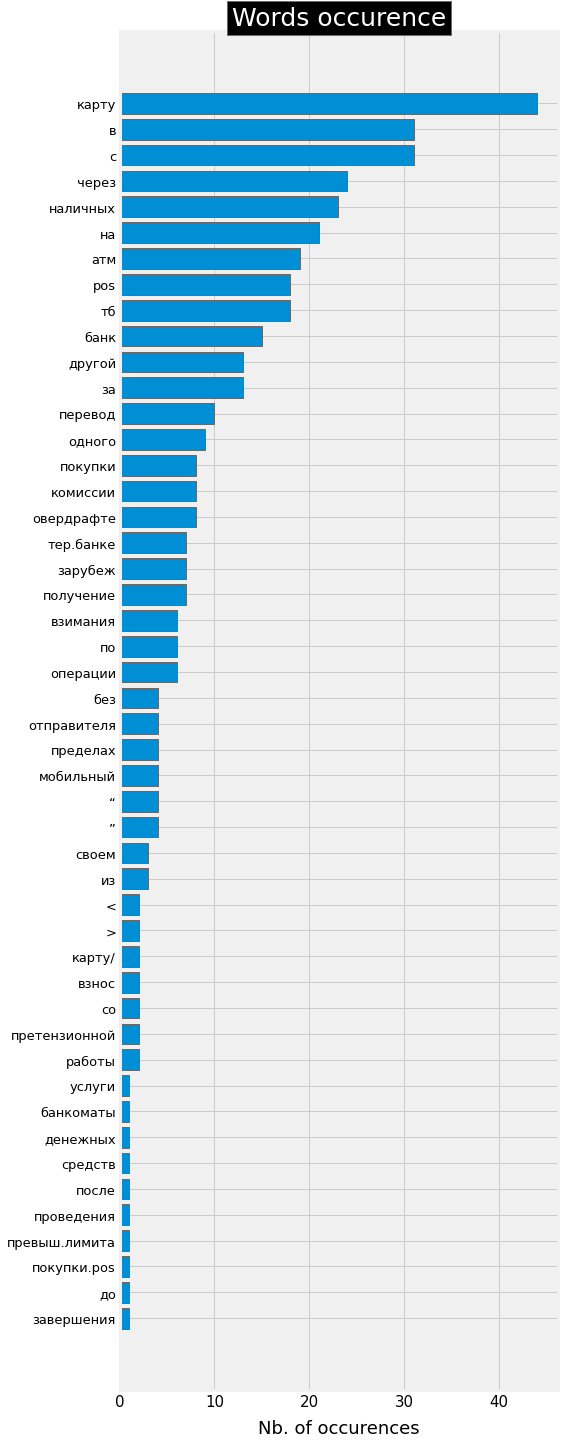

In [51]:
liste = sorted(list_products, key = lambda x:x[1], reverse = True)
#_______________________________
plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k,i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("Nb. of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()
#_______________________________________________________________________________________
plt.title("Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

In [52]:
keywords_roots.keys()

dict_keys(['наличн', 'в', 'атм', 'через', 'сво', 'тер.банк', 'услуг', 'банкомат', 'покупк', 'pos', 'на', 'карт', 'с', 'банк', 'без', 'взиман', 'комисс', 'отправител', 'предел', 'одн', 'по', 'операц', '<', 'перевод', '>', 'мобильн', 'друг', 'тб', 'за', 'зарубеж', '“', '”', 'из', 'получен', 'денежн', 'средств', 'овердрафт', 'карту/', 'взнос', 'со', 'посл', 'проведен', 'претензион', 'работ', 'превыш.лимит', 'покупки.пос', 'до', 'завершен'])

In [53]:
#there are some symbols in keywords< let's remove them
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
#     if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 : continue
    if ('\"' in word) or ('<' in word) or ('>' in word) or ('/' in word): continue
    list_products.append([word, v])
#______________________________________________________    
list_products.sort(key = lambda x:x[1], reverse = True)
print('mots conservés:', len(list_products))

mots conservés: 34


In [54]:
products=np.array(list_products)
print(products[:,0])

['карту' 'через' 'наличных' 'атм' 'pos' 'банк' 'другой' 'перевод' 'одного'
 'покупки' 'комиссии' 'овердрафте' 'тер.банке' 'зарубеж' 'получение'
 'взимания' 'операции' 'без' 'отправителя' 'пределах' 'мобильный' 'своем'
 'взнос' 'претензионной' 'работы' 'услуги' 'банкоматы' 'денежных'
 'средств' 'после' 'проведения' 'превыш.лимита' 'покупки.pos' 'завершения']


In [55]:
list_products2 = transactions_df['type_description'].unique()
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), list_products2))

In [56]:
transactions_df['type_description'].values

array(['Выдача наличных в АТМ',
       'Взнос наличных через АТМ (в своем тер.банке)',
       'Выдача наличных в АТМ', ..., 'Покупка. POS ', 'Покупка. POS ',
       'Покупка. POS '], dtype=object)

In [57]:
matrix=[[s.count(w) for w in products[:,0]] for s in df_types['type_description'].values]
# print(matrix)
df_m=pd.DataFrame(matrix, columns=products[:,0], index=df_types)
df_m

,карту,через,наличных,атм,pos,банк,другой,перевод,одного,покупки,...,работы,услуги,банкоматы,денежных,средств,после,проведения,превыш.лимита,покупки.pos,завершения
"(Выдача наличных в АТМ,)",0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(Взнос наличных через АТМ (в своем тер.банке),)",0,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(Оплата услуги. Банкоматы,)",0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
"(Покупка. POS ,)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(Перевод на карту (с карты) через Мобильный банк (без взимания комиссии с отправителя),)",1,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(Перевод на карту (с карты) через АТМ (в пределах одного тер.банка),)",1,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
"(Списание с карты на карту по операции <перевода с карты на карту> через Мобильный банк (с комиссией),)",2,1,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
"(Выдача наличных в АТМ банка (в других ТБ),)",0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(Плата за перевод на карту (с карты) через Мобильный банк,)",1,1,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
"(Покупка.,)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
for n_clusters in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(df_m)
    clusters = kmeans.predict(df_m)
    silhouette_avg = silhouette_score(df_m, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.25727010267588607
For n_clusters = 4 The average silhouette_score is : 0.2951444075999244
For n_clusters = 5 The average silhouette_score is : 0.3012123464829128
For n_clusters = 6 The average silhouette_score is : 0.30412657441474344
For n_clusters = 7 The average silhouette_score is : 0.33198232584823745
For n_clusters = 8 The average silhouette_score is : 0.3474198456808334
For n_clusters = 9 The average silhouette_score is : 0.38263003815958624


In [59]:
n_clusters = 5
silhouette_avg = -1
while silhouette_avg < 0.145:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    
    #km = kmodes.KModes(n_clusters = n_clusters, init='Huang', n_init=2, verbose=0)
    #clusters = km.fit_predict(matrix)
    #silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 5 The average silhouette_score is : 0.2788450581270841


In [60]:
pd.Series(clusters).value_counts()

4    17
3    13
2    12
1     7
0     7
dtype: int64

In [61]:
# df_types['categ']=clusters
# df_types.reset_index(inplace=True)
# df_temp=df_types.rename(columns={'index':'type'})
# df_temp.drop('type_description',axis=1, inplace=True)
# df_temp
df_types['categ']=clusters
df_types

,type_description,categ
0,Выдача наличных в АТМ,1
1,Взнос наличных через АТМ (в своем тер.банке),3
2,Оплата услуги. Банкоматы,4
3,Покупка. POS,4
4,Перевод на карту (с карты) через Мобильный бан...,0
5,Перевод на карту (с карты) через АТМ (в предел...,2
6,Списание с карты на карту по операции <перевод...,2
7,Выдача наличных в АТМ банка (в других ТБ),1
8,Плата за перевод на карту (с карты) через Моби...,2
9,Покупка.,4


In [62]:
transactions_df=transactions_df.merge(df_types, how='left', on='type_description')

In [63]:
for i in range(5):
    col = 'type_categ_{}'.format(i)        
    df_temp = transactions_df[transactions_df.categ == i]
    transactions_df.loc[:, col] = df_temp['sum']
    transactions_df[col].fillna(0, inplace = True)
#__________________________________________________________________________________________________
transactions_df.groupby('client_id').sum()

,code,type,sum,categ,type_categ_0,type_categ_1,type_categ_2,type_categ_3,type_categ_4
client_id,,,,,,,,,
22899,51818,34391,50847.54,23,17967.33,-17518.14,22459.16,44918.32,-16979.13
27914,21649,16090,74115.21,14,0.00,0.00,0.00,78607.05,-4491.84
28753,71894,22130,-2589800.29,47,0.00,0.00,-2754615.70,673774.73,-508959.32
31385,70143,27421,-83525.38,44,0.00,-78607.05,0.00,38180.57,-43098.90
38084,141335,70520,693495.66,78,-224591.58,-202132.42,-224591.58,1751814.31,-407003.07
...,...,...,...,...,...,...,...,...,...
99967537,6011,2010,-336887.37,1,0.00,-336887.37,0.00,0.00,0.00
99984336,24044,23040,78607.06,10,0.00,-179673.26,0.00,258280.32,0.00
99985917,6011,2010,-224591.58,1,0.00,-224591.58,0.00,0.00,0.00


In [64]:
df_codes = pd.DataFrame(transactions_df['code_description'].unique()).rename(columns = {0: 'code_description'})
#unique names of types
print(df_codes.shape)
df_codes

(175, 1)


,code_description
0,Финансовые институты — снятие наличности автом...
1,"Звонки с использованием телефонов, считывающих..."
2,"Бакалейные магазины, супермаркеты"
3,Финансовые институты — снятие наличности вручную
4,Магазины с продажей спиртных напитков на вынос...
...,...
170,Прямой маркетинг — комбинированный каталог и т...
171,Автобусные линии
172,Почтовые услуги — только правительство
173,Разнообразные издательства/печатное дело


In [65]:
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, colonne = 'code_description'):
    stemmer = nltk.stem.SnowballStemmer("russian")
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)]

        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1

    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]

    print("Nb of keywords in variable '{}': {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

In [66]:
keywords1, keywords_roots1, keywords_select1, count_keywords1 = keywords_inventory(df_codes)

Nb of keywords in variable 'code_description': 389


In [67]:
keywords_roots1.keys()

dict_keys(['институт', '—', 'снят', 'наличн', 'автоматическ', 'с', 'использован', 'телефон', 'считыва', 'магнитн', 'лент', 'бакалейн', 'магазин', 'супермаркет', 'вручн', 'продаж', 'спиртн', 'напитк', 'на', 'вынос', 'пив', 'вин', 'и', 'ликер', 'продовольствен', 'рынк', 'со', 'спец-ассортимент', 'полуфабрикат', 'фирмен', 'блюд', 'помощ', 'торгов', 'автомат', 'одежд', 'аксессуар', 'станц', 'техобслуживан', 'грузов', 'транспорт', 'сервис', 'ремонт', 'запчаст', 'лизинг', 'универмаг', 'денежн', 'перевод', 'универсальн', 'обувн', 'профессиональн', 'услуг', 'нигд', 'ран', 'не', 'классифицируем', 'авиалин', 'авиакомпан', 'правительствен', 'маркетинг', 'торговл', 'через', 'каталог', 'галереи/учрежден', 'видеоигр', 'рекламн', 'бизнес-сервис', 'рестора', 'закусочн', 'по', 'азартн', 'игр', 'обществен', 'питан', 'аптек', 'товар', 'общ', 'назначен', 'транспортировк', 'бол', 'классифицирова', 'бассейн', 'распродаж', 'косметик', 'офисн', 'школьн', 'принадлежн', 'канцтовар', 'мужск', 'женск', 'бар', 'ди

In [68]:
list_code_words = []
for k,v in count_keywords1.items():
    list_code_words.append([keywords_select1[k], v])
list_code_words.sort(key = lambda x:x[1], reverse = True)
print(list_code_words)

[['и', 56], ['—', 26], ['магазины', 19], ['для', 15], ['не', 14], ['продаже', 13], ['по', 13], ['услуги', 12], ['нигде', 12], ['одежду', 9], ['товары', 9], ['ранее', 8], ['классифицированные', 8], ['изделий', 8], ['оборудование', 7], ['классифицируемые', 6], ['маркетинг', 6], ['более', 6], ['принадлежности', 5], ['институты', 4], ['бытовые', 4], ['в', 4], ['розницу', 4], ['включая', 4], ['с', 3], ['на', 3], ['торговых', 3], ['аксессуары', 3], ['сервис', 3], ['ремонт', 3], ['переводы', 3], ['торговля', 3], ['общий', 3], ['офисные', 3], ['обеспечение', 3], ['агентство', 3], ['другие', 3], ['снятие', 2], ['наличности', 2], ['телефонов', 2], ['напитков', 2], ['запчасти', 2], ['денежные', 2], ['профессиональные', 2], ['авиалинии', 2], ['авиакомпании', 2], ['каталог', 2], ['видеоигр', 2], ['рестораны', 2], ['игры', 2], ['общественные', 2], ['аптеки', 2], ['назначения', 2], ['мужской', 2], ['женской', 2], ['клубы', 2], ['дорожные', 2], ['спортивная', 2], ['езды', 2], ['компьютерное', 2], ['пр

In [69]:
count_keywords1

{'институт': 4,
 '—': 26,
 'снят': 2,
 'наличн': 2,
 'автоматическ': 1,
 'с': 3,
 'использован': 1,
 'телефон': 2,
 'считыва': 1,
 'магнитн': 1,
 'лент': 1,
 'бакалейн': 1,
 'магазин': 19,
 'супермаркет': 1,
 'вручн': 1,
 'продаж': 13,
 'спиртн': 1,
 'напитк': 2,
 'на': 3,
 'вынос': 1,
 'пив': 1,
 'вин': 1,
 'и': 56,
 'ликер': 1,
 'продовольствен': 1,
 'рынк': 1,
 'со': 1,
 'спец-ассортимент': 1,
 'полуфабрикат': 1,
 'фирмен': 1,
 'блюд': 1,
 'помощ': 1,
 'торгов': 3,
 'автомат': 1,
 'одежд': 9,
 'аксессуар': 3,
 'станц': 1,
 'техобслуживан': 1,
 'грузов': 1,
 'транспорт': 1,
 'сервис': 3,
 'ремонт': 3,
 'запчаст': 2,
 'лизинг': 1,
 'универмаг': 1,
 'денежн': 2,
 'перевод': 3,
 'универсальн': 1,
 'обувн': 1,
 'профессиональн': 2,
 'услуг': 12,
 'нигд': 12,
 'ран': 8,
 'не': 14,
 'классифицируем': 6,
 'авиалин': 2,
 'авиакомпан': 2,
 'правительствен': 1,
 'маркетинг': 6,
 'торговл': 3,
 'через': 1,
 'каталог': 2,
 'галереи/учрежден': 1,
 'видеоигр': 2,
 'рекламн': 1,
 'бизнес-сервис': 1

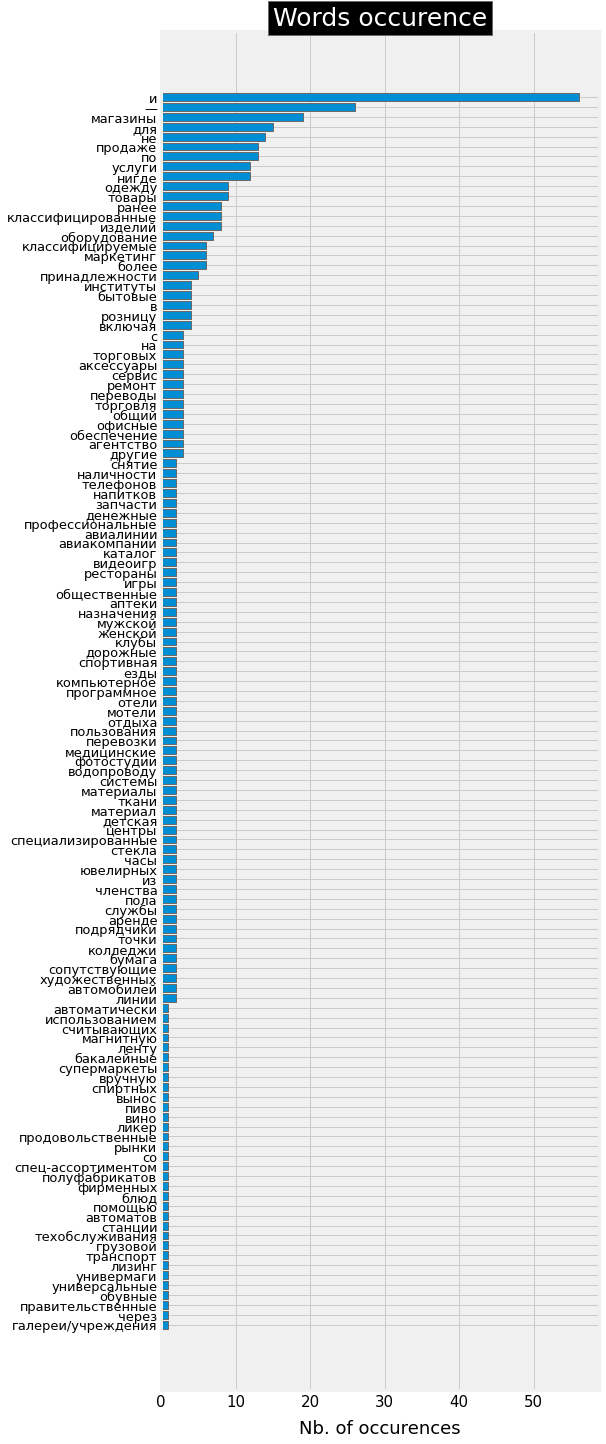

In [70]:
list_code = sorted(list_code_words, key = lambda x:x[1], reverse = True)
#_______________________________
plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in list_code[:125]]
x_axis = [k for k,i in enumerate(list_code[:125])]
x_label = [i[0] for i in list_code[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("Nb. of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()
#_______________________________________________________________________________________
plt.title("Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

In [71]:
#there are some symbols in keywords< let's remove them
list_code_words = []
for k,v in count_keywords1.items():
    word = keywords_select1[k]
    #     if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 : continue
    if ('-' in word): continue
    list_code_words.append([word, v])
#______________________________________________________
list_code_words.sort(key = lambda x:x[1], reverse = True)
print('mots conservés:', len(list_code_words))

mots conservés: 373


In [72]:
code_words=np.array(list_code_words)
print(code_words[:, 0])

['магазины' 'для' 'продаже' 'услуги' 'нигде' 'одежду' 'товары' 'ранее'
 'классифицированные' 'изделий' 'оборудование' 'классифицируемые'
 'маркетинг' 'более' 'принадлежности' 'институты' 'бытовые' 'розницу'
 'включая' 'торговых' 'аксессуары' 'сервис' 'ремонт' 'переводы' 'торговля'
 'общий' 'офисные' 'обеспечение' 'агентство' 'другие' 'снятие'
 'наличности' 'телефонов' 'напитков' 'запчасти' 'денежные'
 'профессиональные' 'авиалинии' 'авиакомпании' 'каталог' 'видеоигр'
 'рестораны' 'игры' 'общественные' 'аптеки' 'назначения' 'мужской'
 'женской' 'клубы' 'дорожные' 'спортивная' 'езды' 'компьютерное'
 'программное' 'отели' 'мотели' 'отдыха' 'пользования' 'перевозки'
 'медицинские' 'фотостудии' 'водопроводу' 'системы' 'материалы' 'ткани'
 'материал' 'детская' 'центры' 'специализированные' 'стекла' 'часы'
 'ювелирных' 'членства' 'пола' 'службы' 'аренде' 'подрядчики' 'точки'
 'колледжи' 'бумага' 'сопутствующие' 'художественных' 'автомобилей'
 'линии' 'автоматически' 'использованием' 'считываю

In [73]:
code_words2 = transactions_df['type_description'].unique()
X = pd.DataFrame()
for key, occurence in list_code_words:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), code_words2))

In [74]:
matrix_codes=[[s.count(w) for w in code_words[:, 0]] for s in df_codes['code_description'].values]
# print(matrix)
df_m_code=pd.DataFrame(matrix_codes, columns=code_words[:, 0], index=df_codes)
df_m_code


,магазины,для,продаже,услуги,нигде,одежду,товары,ранее,классифицированные,изделий,...,электроприборы,комбинированный,торговцы,автобусные,только,правительство,издательства/печатное,дело,смежные,вещества
"(Финансовые институты — снятие наличности автоматически,)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(Звонки с использованием телефонов, считывающих магнитную ленту,)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(Бакалейные магазины, супермаркеты,)",1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(Финансовые институты — снятие наличности вручную,)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(Магазины с продажей спиртных напитков на вынос (пиво, вино и ликер),)",0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(Прямой маркетинг — комбинированный каталог и торговцы в розницу,)",0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
"(Автобусные линии,)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(Почтовые услуги — только правительство,)",0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
"(Разнообразные издательства/печатное дело,)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0


In [75]:
for n_clusters in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(df_m_code)
    clusters = kmeans.predict(df_m_code)
    silhouette_avg = silhouette_score(df_m_code, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.11502346145767649
For n_clusters = 4 The average silhouette_score is : 0.033212327963575476
For n_clusters = 5 The average silhouette_score is : 0.12913610973906126
For n_clusters = 6 The average silhouette_score is : 0.03824987588480534
For n_clusters = 7 The average silhouette_score is : 0.13204751828436043
For n_clusters = 8 The average silhouette_score is : 0.13038082557330688
For n_clusters = 9 The average silhouette_score is : 0.02092785827807517


In [76]:
n_clusters = 3
silhouette_avg = -1
while silhouette_avg < 0.12:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix_codes)
    clusters = kmeans.predict(matrix_codes)
    silhouette_avg = silhouette_score(matrix_codes, clusters)

print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.12778403470110342


In [77]:
pd.Series(clusters).value_counts()

0    139
1     30
2      6
dtype: int64

In [78]:
df_codes['code_categ']=clusters
df_codes

,code_description,code_categ
0,Финансовые институты — снятие наличности автом...,0
1,"Звонки с использованием телефонов, считывающих...",0
2,"Бакалейные магазины, супермаркеты",1
3,Финансовые институты — снятие наличности вручную,0
4,Магазины с продажей спиртных напитков на вынос...,1
...,...,...
170,Прямой маркетинг — комбинированный каталог и т...,0
171,Автобусные линии,0
172,Почтовые услуги — только правительство,0
173,Разнообразные издательства/печатное дело,0


In [79]:
transactions_df=transactions_df.merge(df_codes, how='left', on='code_description')

In [80]:
for i in range(5):
    col = 'code_categ_{}'.format(i)
    df_temp = transactions_df[transactions_df.categ == i]
    transactions_df.loc[:, col] = df_temp['sum']
    transactions_df[col].fillna(0, inplace = True)
#__________________________________________________________________________________________________
new_df=transactions_df.groupby('client_id').sum().drop(['code', 'type','categ','code_categ'],axis=1)
new_df.reset_index(col_fill='client_id',inplace=True)
new_df

,client_id,sum,type_categ_0,type_categ_1,type_categ_2,type_categ_3,type_categ_4,code_categ_0,code_categ_1,code_categ_2,code_categ_3,code_categ_4
0,22899,50847.54,17967.33,-17518.14,22459.16,44918.32,-16979.13,17967.33,-17518.14,22459.16,44918.32,-16979.13
1,27914,74115.21,0.00,0.00,0.00,78607.05,-4491.84,0.00,0.00,0.00,78607.05,-4491.84
2,28753,-2589800.29,0.00,0.00,-2754615.70,673774.73,-508959.32,0.00,0.00,-2754615.70,673774.73,-508959.32
3,31385,-83525.38,0.00,-78607.05,0.00,38180.57,-43098.90,0.00,-78607.05,0.00,38180.57,-43098.90
4,38084,693495.66,-224591.58,-202132.42,-224591.58,1751814.31,-407003.07,-224591.58,-202132.42,-224591.58,1751814.31,-407003.07
...,...,...,...,...,...,...,...,...,...,...,...,...
8651,99967537,-336887.37,0.00,-336887.37,0.00,0.00,0.00,0.00,-336887.37,0.00,0.00,0.00
8652,99984336,78607.06,0.00,-179673.26,0.00,258280.32,0.00,0.00,-179673.26,0.00,258280.32,0.00
8653,99985917,-224591.58,0.00,-224591.58,0.00,0.00,0.00,0.00,-224591.58,0.00,0.00,0.00
8654,99991245,569609.16,0.00,0.00,-67377.47,653561.49,-16574.86,0.00,0.00,-67377.47,653561.49,-16574.86


In [81]:
# Standardize the data to all be the same unit
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(new_df.drop('client_id', axis=1))

# Transforming the data
scaled_features = scaler.transform(new_df.drop('client_id', axis=1))
scaled_features

array([[ 0.11312706, -0.01097708,  0.2386688 , ...,  0.06165666,
        -0.14717899,  0.28747164],
       [ 0.1213069 , -0.01659055,  0.25147202, ...,  0.03246081,
        -0.11261221,  0.31587686],
       [-0.81520263, -0.01659055,  0.25147202, ..., -3.54840954,
         0.49806776, -0.83165078],
       ...,
       [ 0.0162954 , -0.01659055,  0.08732809, ...,  0.03246081,
        -0.19326805,  0.32609459],
       [ 0.29549967, -0.01659055,  0.25147202, ..., -0.05512672,
         0.47732768,  0.28839125],
       [-0.13381932, -0.01659055, -0.10865975, ...,  0.03246081,
        -0.19326805, -0.03522654]])

In [82]:
df_feat = pd.DataFrame(scaled_features, columns=new_df.columns[:-1])
df_feat['client_id']=new_df['client_id']
df_feat

,client_id,sum,type_categ_0,type_categ_1,type_categ_2,type_categ_3,type_categ_4,code_categ_0,code_categ_1,code_categ_2,code_categ_3
0,22899,-0.010977,0.238669,0.061657,-0.147179,0.287472,-0.010977,0.238669,0.061657,-0.147179,0.287472
1,27914,-0.016591,0.251472,0.032461,-0.112612,0.315877,-0.016591,0.251472,0.032461,-0.112612,0.315877
2,28753,-0.016591,0.251472,-3.548410,0.498068,-0.831651,-0.016591,0.251472,-3.548410,0.498068,-0.831651
3,31385,-0.016591,0.194022,0.032461,-0.154092,0.228056,-0.016591,0.194022,0.032461,-0.154092,0.228056
4,38084,-0.086759,0.103742,-0.259498,1.604205,-0.599728,-0.086759,0.103742,-0.259498,1.604205,-0.599728
...,...,...,...,...,...,...,...,...,...,...,...
8651,99967537,-0.016591,0.005256,0.032461,-0.193268,0.326095,-0.016591,0.005256,0.032461,-0.193268,0.326095
8652,99984336,-0.016591,0.120157,0.032461,0.071744,0.326095,-0.016591,0.120157,0.032461,0.071744,0.326095
8653,99985917,-0.016591,0.087328,0.032461,-0.193268,0.326095,-0.016591,0.087328,0.032461,-0.193268,0.326095
8654,99991245,-0.016591,0.251472,-0.055127,0.477328,0.288391,-0.016591,0.251472,-0.055127,0.477328,0.288391


In [83]:
df_train = pd.merge(train_df, df_feat, on="client_id")
X_test = pd.merge(test_df, df_feat, on="client_id")

X_train = df_train.drop(['target'],axis=1)
y_train = df_train.target

X_train

,client_id,sum,type_categ_0,type_categ_1,type_categ_2,type_categ_3,type_categ_4,code_categ_0,code_categ_1,code_categ_2,code_categ_3
0,75063019,-0.074830,0.175966,-0.045930,0.359801,0.098710,-0.074830,0.175966,-0.045930,0.359801,0.098710
1,86227647,-0.076234,-0.050553,0.032461,-0.066523,0.040769,-0.076234,-0.050553,0.032461,-0.066523,0.040769
2,6506523,0.208481,0.171041,0.388971,1.682556,0.150894,0.208481,0.171041,0.388971,1.682556,0.150894
3,50615998,-0.025011,0.251472,0.032461,-0.193268,0.290333,-0.025011,0.251472,0.032461,-0.193268,0.290333
4,95213230,-0.016591,0.200587,0.616378,-0.193268,-0.049844,-0.016591,0.200587,0.616378,-0.193268,-0.049844
...,...,...,...,...,...,...,...,...,...,...,...
5995,71577803,-0.016591,0.251472,0.032461,-0.193268,0.065406,-0.016591,0.251472,0.032461,-0.193268,0.065406
5996,8128547,-0.016591,0.159551,0.032461,-0.335798,0.330582,-0.016591,0.159551,0.032461,-0.335798,0.330582
5997,26055781,-0.016591,0.235058,0.022242,-0.193268,0.297562,-0.016591,0.235058,0.022242,-0.193268,0.297562
5998,73504380,0.157076,0.115233,0.032461,-0.193268,-0.687175,0.157076,0.115233,0.032461,-0.193268,-0.687175


In [84]:
X_test

,client_id,sum,type_categ_0,type_categ_1,type_categ_2,type_categ_3,type_categ_4,code_categ_0,code_categ_1,code_categ_2,code_categ_3
0,61240380,-0.016591,0.169400,0.032461,-0.193268,0.024161,-0.016591,0.169400,0.032461,-0.193268,0.024161
1,34114030,-0.016591,0.144778,0.032461,0.136269,0.315364,-0.016591,0.144778,0.032461,0.136269,0.315364
2,15926722,-0.016591,-0.045628,0.032461,-0.193268,0.326095,-0.016591,-0.045628,0.032461,-0.193268,0.326095
3,50598019,0.007277,0.210436,0.032461,-0.186355,0.031988,0.007277,0.210436,0.032461,-0.186355,0.031988
4,76475250,-0.016591,-1.135544,0.382811,0.008372,-9.694583,-0.016591,-1.135544,0.382811,0.008372,-9.694583
...,...,...,...,...,...,...,...,...,...,...,...
2651,13491189,-0.129632,0.248189,0.049978,0.037177,0.135075,-0.129632,0.248189,0.049978,0.037177,0.135075
2652,54047312,-0.016591,0.192380,0.178440,0.498068,0.252334,-0.016591,0.192380,0.178440,0.498068,0.252334
2653,68859452,-0.016591,0.103742,0.032461,-0.193268,0.017217,-0.016591,0.103742,0.032461,-0.193268,0.017217
2654,95721840,-0.016591,0.236699,0.032461,-0.193268,0.285305,-0.016591,0.236699,0.032461,-0.193268,0.285305


In [85]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier()

[Text(0.35062716803758115, 0.9916666666666667, 'code_categ_0 <= 0.092\ngini = 0.494\nsamples = 6000\nvalue = [3340, 2660]'),
 Text(0.22210661995280143, 0.975, 'code_categ_2 <= 1.068\ngini = 0.498\nsamples = 2000\nvalue = [936, 1064]'),
 Text(0.11624320420442724, 0.9583333333333334, 'type_categ_0 <= -0.314\ngini = 0.5\nsamples = 1867\nvalue = [908, 959]'),
 Text(0.03601953006987555, 0.9416666666666667, 'type_categ_2 <= 0.705\ngini = 0.48\nsamples = 487\nvalue = [195, 292]'),
 Text(0.025780211998063886, 0.925, 'sum <= -0.688\ngini = 0.473\nsamples = 471\nvalue = [181, 290]'),
 Text(0.024948592256190855, 0.9083333333333333, 'gini = 0.0\nsamples = 12\nvalue = [0, 12]'),
 Text(0.026611831739936913, 0.9083333333333333, 'client_id <= 36042162.0\ngini = 0.478\nsamples = 459\nvalue = [181, 278]'),
 Text(0.010291294305678728, 0.8916666666666667, 'client_id <= 3002595.5\ngini = 0.429\nsamples = 154\nvalue = [48, 106]'),
 Text(0.003326478967492114, 0.875, 'client_id <= 507631.5\ngini = 0.495\nsamp

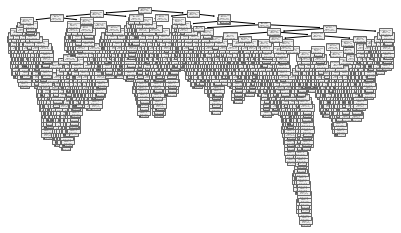

In [86]:
plot_tree(model, feature_names = X_train.columns)

In [87]:
model.predict_proba(X_test)

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [88]:
model = DecisionTreeClassifier(random_state=0, max_depth=4)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=0)

[Text(0.5431034482758621, 0.9, 'code_categ_0 <= 0.092\ngini = 0.494\nsamples = 6000\nvalue = [3340, 2660]'),
 Text(0.27586206896551724, 0.7, 'code_categ_2 <= 1.068\ngini = 0.498\nsamples = 2000\nvalue = [936, 1064]'),
 Text(0.13793103448275862, 0.5, 'code_categ_0 <= -0.314\ngini = 0.5\nsamples = 1867\nvalue = [908, 959]'),
 Text(0.06896551724137931, 0.3, 'code_categ_2 <= 0.705\ngini = 0.48\nsamples = 487\nvalue = [195, 292]'),
 Text(0.034482758620689655, 0.1, 'gini = 0.473\nsamples = 471\nvalue = [181, 290]'),
 Text(0.10344827586206896, 0.1, 'gini = 0.219\nsamples = 16\nvalue = [14, 2]'),
 Text(0.20689655172413793, 0.3, 'code_categ_3 <= -0.812\ngini = 0.499\nsamples = 1380\nvalue = [713, 667]'),
 Text(0.1724137931034483, 0.1, 'gini = 0.444\nsamples = 75\nvalue = [25, 50]'),
 Text(0.2413793103448276, 0.1, 'gini = 0.499\nsamples = 1305\nvalue = [688, 617]'),
 Text(0.41379310344827586, 0.5, 'client_id <= 56199976.0\ngini = 0.332\nsamples = 133\nvalue = [28, 105]'),
 Text(0.344827586206896

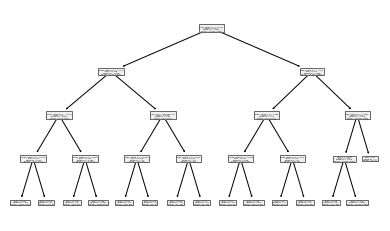

In [89]:
plot_tree(model, feature_names = X_train.columns)

In [90]:
model.predict_proba(X_test)

array([[0.62543171, 0.37456829],
       [0.62543171, 0.37456829],
       [0.52720307, 0.47279693],
       ...,
       [0.62543171, 0.37456829],
       [0.62543171, 0.37456829],
       [0.62543171, 0.37456829]])